In [1]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score, mean_squared_error
import xgboost as xgb
import optuna
import talib
import json
import pickle
import torch
import os
import logging
from scipy.stats.mstats import winsorize
from plotly.subplots import make_subplots
import seaborn as sns
from imblearn.over_sampling import SMOTEN
import smogn
import warnings
from datetime import datetime, timedelta

In [2]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file = "logstraining_logs_xgRegPower_v16_1minute.txt"
log_file_path = os.path.join(log_dir, log_file)
print(log_file_path)
logging.basicConfig(
    filename=log_file_path,
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

logging.info("Logging started")

logs\logstraining_logs_xgRegPower_v16_1minute.txt


#### Defining all config values

In [64]:
config = {}
config['all_data_excel_path'] = "../data/SPY_AllData.xlsx"
#Bollinger Band
config['bolband_period'] = 20
config['bolband_width'] = 2
#Donchian Channel
config['donchn_period'] = 20
#TCHR
config['tchr_period'] = 100
config['tchr_retracement'] = "long"
config['tchr_adj'] = 5
config['tchr_range'] = "highlow"
#Momentum
config['momentum_period'] = 10
#Volatility
config['volatility_period'] = 14
#ATR
config['atr_period'] = 14
config['atr_ma'] = 20

#Fourier Transform
config['fourier_period'] = 50

#number of bars to check for output
config['num_bars_output'] = 20

#Features Definition
config['Close_Diff_Features'] =  "BOLLBU,BOLLBL,DONUP,DONLOW,MA20,MA50,MA100,EMA20,PVPTR1,PVPTR2,PVPTR3,PVPT,PVPTS1,PVPTS2,PVPTS3"
config['training_features'] =  "BOLLBU,BOLLBL,DONUP,DONLOW,MA20,MA50,MA100,EMA20,PVPTR1,PVPTR2,PVPTR3,PVPT,PVPTS1,PVPTS2,PVPTS3,TCHR,ADJATR,Volatility,Momentum"
config['minmax_features'] = "BOLLBU,BOLLBL,DONUP,DONLOW,MA20,MA50,MA100,EMA20,PVPTR1,PVPTR2,PVPTR3,PVPT,PVPTS1,PVPTS2,PVPTS3,TCHR,ADJATR,Volatility,Momentum"


In [7]:
all_trading_data_dfs = []
sheet_names = ['1minData1-6-2022', '1minData1-12-2023', '1minData1-22-2024']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])

In [8]:
##### Set the Date Start and End for the filtering of trading data
train_start_date = pd.to_datetime('2023-12-01')
train_end_date = pd.to_datetime('2023-12-31')
trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.drop(columns=['Symbol'], inplace=True)

In [9]:
trading_data_raw.shape

(7800, 6)

#### Transforming Functions

In [61]:
def normalize_timegaps(df, time_gap_threshold=60):
    df = df.copy()
    features = ['Open', 'High', 'Low', 'Close']
    df['time_delta'] = df['Date'].diff().dt.total_seconds()
    df['time_delta'] = df['time_delta'].fillna(df['time_delta'].median())
    df['time_gap_flag'] = df['time_delta'] > time_gap_threshold
    gap_indices = df.index[df['time_gap_flag']].tolist()
    adjustment_factor = 1.0

    for p in gap_indices:
        if p > 0: # ensure p-1 exist
            prev_close = df.loc[p-1, 'Close']
            new_close = df.loc[p, 'Open']
            gap_percentage = new_close / prev_close
            adjustment_factor *= gap_percentage
            df.loc[:p-1, features] *= gap_percentage
    return df

def transform_features(df):
    close_diff_features = config['Close_Diff_Features'].split(',')
    df[close_diff_features] = df[close_diff_features].sub(df['Close'], axis=0).div(df['Close'], axis=0)
    return df

def min_max_scaling(df, inference=True, scaler=None):
    features = config['minmax_features'].split(',')
    if not inference:
        scaler = MinMaxScaler()
        df[features] = scaler.fit_transform(df[features])
        return df, scaler
    else:
        df[features] = scaler.transform(df[features])
        return df

#### UTilities

In [58]:
def get_fourier_columns():
    fourier_cols = []
    period = config['fourier_period']
    n_components = (period - 2) // 2 
    for i in range(1, n_components+1):
        fourier_cols.append(f'fourier_real_{i}')
        fourier_cols.append(f'fourier_imag_{i}')
    return fourier_cols

def get_all_training_features():
    training_features = config['training_features'].split(',')
    fourier_cols = get_fourier_columns()
    return training_features + fourier_cols

def plot_feature_distributions(df, bins=50):
    numeric_features = get_all_training_features()
    num_features = len(numeric_features)

    plt.figure(figsize=(16, num_features * 3))  # Adjust figure size dynamically

    for i, feature in enumerate(numeric_features, 1):
        plt.subplot((num_features // 3) + 1, 3, i)  # Arrange in 3 columns
        sns.histplot(df[feature], bins=bins, kde=True, color="blue", edgecolor="black", alpha=0.7)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

In [14]:
trading_data_time_normalized = normalize_timegaps(trading_data_raw)

In [15]:
toplot_df = trading_data_time_normalized

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1,
                    subplot_titles=("CandleStick Chart Norm", "CandleStick Chart"))
fig.add_trace(
    go.Candlestick(
        x=toplot_df['Date'], 
        open=toplot_df['Open'], 
        high=toplot_df['High'], 
        low=toplot_df['Low'], 
        close=toplot_df['Close'],
        name='OHLC Norm'
        ), row=1, col=1
)

fig.add_trace(
    go.Candlestick(
        x=trading_data_raw['Date'], 
        open=trading_data_raw['Open'], 
        high=trading_data_raw['High'], 
        low=trading_data_raw['Low'], 
        close=trading_data_raw['Close'],
        name='OHLC'
        ), row=2,col=1
)

fig.update_layout(
    title='CandleStick chart of time normalized',
    xaxis=dict(type="date", 
               rangebreaks=[
                   dict(bounds=["sat", "mon"]),
                   dict(bounds=[16,9.5], pattern='hour')
               ]              
            ),
    xaxis_rangeslider_visible=False,
    height=600,
    hovermode='x unified'
)



fig.update_xaxes(matches='x')

fig.show()

#### Functions for calculating the features

In [32]:
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_volatility_momentum(df, price_col='Close', vol_window=14, mom_window=10):
    """
    Computes rolling volatility and momentum for a given price column.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical price data.
        price_col (str): Column name of the closing price.
        vol_window (int): Window size for rolling volatility calculation.
        mom_window (int): Window size for momentum calculation.

    Returns:
        pd.DataFrame: DataFrame with added 'Volatility' and 'Momentum' features.
    """

    # Ensure price column exists
    if price_col not in df.columns:
        raise ValueError(f"Column '{price_col}' not found in DataFrame")

    # 🔹 Compute Log Returns (for better volatility calculation)
    df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1))

    # 🔹 Compute Rolling Volatility (Standard Deviation of Log Returns)
    df['Volatility'] = df['Log_Returns'].rolling(window=vol_window).std()

    # 🔹 Compute Momentum (Rate of Change in Price)
    df['Momentum'] = df[price_col].pct_change(periods=mom_window) * 100

    # 🔹 Drop NaN values from rolling computations
    #df.dropna(inplace=True)

    return df

def compute_fourier_df(df):
    period = config['fourier_period']
    n_components = (period - 2) // 2 
    for i in range(n_components):
        df[f'fourier_real_{i+1}'] = np.nan
        df[f'fourier_imag_{i+1}'] = np.nan
    
    for i in range(len(df)):
        if i >= period - 1:
            #print("entered point 1")
            close_window = df['Close'].iloc[i - period + 1: i + 1].values
            fft_result = np.fft.fft(close_window)
            real = fft_result.real
            imag = fft_result.imag

            for j in range(1, n_components+1):
                df.iloc[i, df.columns.get_loc(f'fourier_real_{j}')] = real[j]
                df.iloc[i, df.columns.get_loc(f'fourier_imag_{j}')] = imag[j]
    return df

In [30]:
def add_new_features_df(data):
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBL'] = lower
    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)
    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)
    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)
    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']
    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']
    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']
    data['PVPTS2'] = data['PVPT'] - (data['High'] - data['Low'])
    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_ATR(data)

    data = compute_volatility_momentum(data, price_col='Close', vol_window=config['volatility_period'], mom_window=config['momentum_period'])
    
    data = compute_fourier_df(data)

    return data


#### Features EDA

In [33]:
trading_data_with_features = add_new_features_df(trading_data_time_normalized)

In [49]:
pd.reset_option('display.max_columns')
pd.set_option('display.max_rows', None)
trading_data_with_features.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7800,2023-12-15 19:56:30,2023-12-01 09:30:00,2023-12-08 05:07:15,2023-12-15 00:44:30,2023-12-21 20:21:45,2023-12-29 15:59:00,NaN
Open,7800.0,471.0433,459.182959,464.918673,473.894255,475.989451,480.622235,5.91738
High,7800.0,471.119107,459.334225,464.99002,474.004322,476.059457,480.666576,5.910532
Low,7800.0,470.96721,459.00144,464.837134,473.79396,475.899481,480.580723,5.92164
Close,7800.0,471.045113,459.172875,464.918196,473.898759,475.985704,480.621124,5.916378
Volume,7800.0,134977.822564,9629.0,60707.0,90106.0,144622.25,7370283.0,250015.50452
time_delta,7800.0,313.153846,60.0,60.0,60.0,60.0,322260.0,6501.431312
BOLLBU,7781.0,471.390015,460.064279,465.331664,474.382171,476.32627,480.62776,5.895624
BOLLBL,7781.0,470.718308,459.101599,464.557858,473.393954,475.558761,480.319845,5.923568
DONUP,7781.0,471.394883,460.060302,465.326371,474.389699,476.32312,480.666576,5.889873


In [50]:
def get_outlier_info(df, threshold=1.5):
    summary = []
    for column in df.select_dtypes(include=[np.number]).columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_outbound = q1 - threshold * iqr
        upper_outbound = q3 + threshold * iqr
        outlier_count = len(df[(df[column] < lower_outbound) | (df[column] > upper_outbound)])

        summary.append({
            'column': column,
            'outlier_count': outlier_count,
            'total_records': len(df),
            'outlier_percentage': outlier_count / len(df) * 100,
            'lower_outbound': lower_outbound,
            'upper_outbound': upper_outbound
        })
    
    summary_df = pd.DataFrame(summary)

    return summary_df

In [53]:
trading_data_transformed = transform_features(trading_data_with_features)

In [54]:
outlier_info = get_outlier_info(trading_data_transformed)

In [55]:
outlier_info

,column,outlier_count,total_records,outlier_percentage,lower_outbound,upper_outbound
0,Open,0,7800,0.000000,448.312507,492.595617
1,High,0,7800,0.000000,448.385865,492.663613
2,Low,0,7800,0.000000,448.243613,492.493001
3,Close,0,7800,0.000000,448.316934,492.586966
4,Volume,589,7800,7.551282,-65165.875000,270495.125000
5,time_delta,19,7800,0.243590,60.000000,60.000000
6,BOLLBU,586,7800,7.512821,-0.000779,0.001827
7,BOLLBL,388,7800,4.974359,-0.002150,0.000865
8,DONUP,540,7800,6.923077,-0.000807,0.001896
9,DONLOW,403,7800,5.166667,-0.002243,0.000823


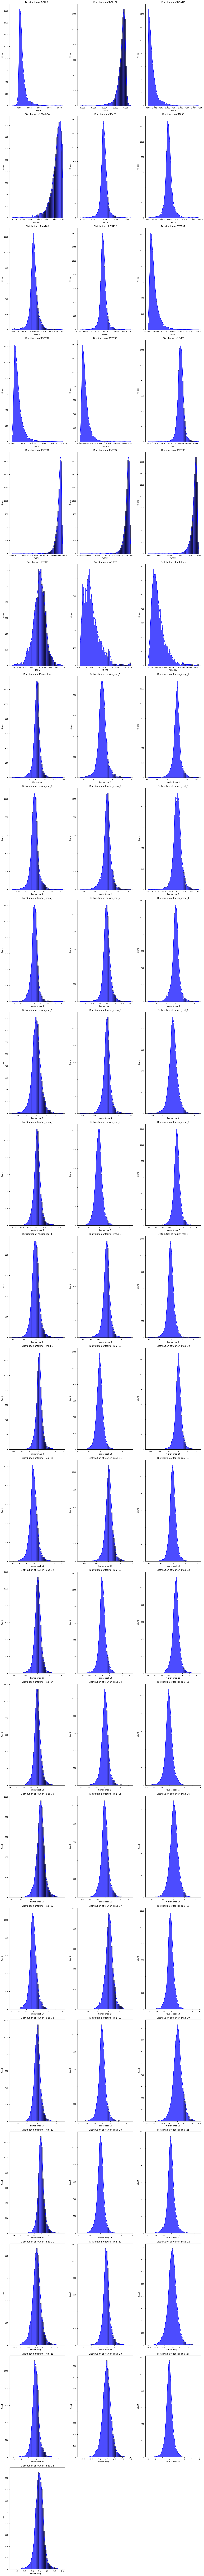

In [57]:
plot_feature_distributions(trading_data_transformed)

In [62]:
trading_data_scaled = trading_data_transformed.copy()
trading_data_scaled, min_scaler = min_max_scaling(trading_data_scaled, inference=False)

In [63]:
trading_data_scaled.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,7800,2023-12-15 19:56:30,2023-12-01 09:30:00,2023-12-08 05:07:15,2023-12-15 00:44:30,2023-12-21 20:21:45,2023-12-29 15:59:00,NaN
Open,7800.0,471.0433,459.182959,464.918673,473.894255,475.989451,480.622235,5.91738
High,7800.0,471.119107,459.334225,464.99002,474.004322,476.059457,480.666576,5.910532
Low,7800.0,470.96721,459.00144,464.837134,473.79396,475.899481,480.580723,5.92164
Close,7800.0,471.045113,459.172875,464.918196,473.898759,475.985704,480.621124,5.916378
Volume,7800.0,134977.822564,9629.0,60707.0,90106.0,144622.25,7370283.0,250015.50452
time_delta,7800.0,313.153846,60.0,60.0,60.0,60.0,322260.0,6501.431312
BOLLBU,7781.0,0.204221,0.0,0.156919,0.180908,0.221768,1.0,0.082174
BOLLBL,7781.0,0.825491,0.0,0.796727,0.847686,0.878329,1.0,0.085514
DONUP,7781.0,0.088008,0.0,0.02664,0.058156,0.113612,1.0,0.097601


In [ ]:
def add_labels(df):
    num_bars = config['num_bars_output']
    df['output'] = df['Close'].shift(-num_bars_output)
    df['output'] = df['output'].sub(df['Close'], axis=0).div(df['Close'], axis=0)
    return df